# Redes Convolucionales

## Instalación e importación de librerías

In [7]:
%pip install split-folders
%pip install opencv-python
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182

In [252]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import splitfolders
import shutil
import tensorflow as tf
import PIL
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

## División y procesamiento de datos

Primero, descargamos y descompriminos la carpeta que se encuentra en el link https://drive.google.com/drive/folders/13FKcZ2IQFWulkQyIzynS6yJKGS8TP51u?usp=drive_link y la metemos en nuestro entorno.

Debemos quitar las imagenes que no tengan un formato válido para realizar data augmentation. Estas imagenes son aquellas que no son JPG o PNG.

In [2]:
def clean_data(dirname):
	directories = os.listdir(dirname)
	for dir in directories:
		img_directories = os.listdir(f"{dirname}/{dir}")
		for img_name in img_directories:
			ext = img_name.split('.')[-1] # Extensión de la imagen se encuentra tras el punto
			if (
				ext != "JPG" and ext != "jpg" and 
				ext != "png" and ext != "jpeg"
			):
				os.remove(f"{dirname}/{dir}/{img_name}")

In [3]:
clean_data("Chessman-image-dataset/Chess")

Ahora, dividimos el dataset entre datos de entrenamiento, de test y validación.

In [4]:
splitfolders.ratio('Chessman-image-dataset/Chess', output="Chessman-image-dataset/split", seed=1337, ratio=(.7, 0.15, 0.15))

Copying files: 551 files [00:02, 212.37 files/s]


Mapeamos las 6 piezas del dataset de número de clase a pieza y estandarizamos el tamaño de las imágenes a 64x64.

In [2]:
MAP_PIECES = {
    0: 'Bishop', 1: 'King', 2: 'Knight',
    3: 'Pawn', 4: 'Queen', 5: 'Rook'
}

IMG_SIZE = 64

Función de carga de datos de entrenamiento.

In [3]:
def load_train_set(dirname, map_pieces, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_pieces: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_pieces.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

Función de carga de datos de prueba.

In [4]:
def load_val_test_set(dirname, map_pieces, set_name, verbose=True):
	"""Esta función funciona de manera equivalente a la función load_train_set
	pero cargando los datos de test."""
	X_test = []
	y_test = []
	reverse_dict = {v: k for k, v in map_pieces.items()}
	for filename in glob.glob(dirname + '/*.*'):
		char_name = "_".join(filename.split('\\')[-1].split('_')[:-1])
		if char_name in reverse_dict:
			image = cv2.imread(filename)
			image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
			X_test.append(image)
			y_test.append(reverse_dict[char_name])
	if verbose:
		print(f"Leídas {len(X_test)} imágenes de {set_name}")
	return np.array(X_test), np.array(y_test)

Debemos transformar los datos de test y validación para que la función los procese correctamente.
Los datos de test se encuentran segmentados en una carpeta por cada pieza por lo que recorremos los directorios y cada una de las imágenes, copiamos cada archivo fuera de la carpeta, añadiéndole el nombre de la pieza de la imagen y luego borramos cada una de estas carpetas.

In [8]:
def transform_val_test_data(dirname):
	test_directories = os.listdir(dirname)

	for dir in test_directories:
		files_to_copy = os.listdir(f"{dirname}/{dir}")
		for file_name in files_to_copy:
			shutil.copy(f"{dirname}/{dir}/{file_name}", f"{dirname}/{dir}_{file_name}") # Le añade el nombre del directorio delante del nombre que tenía
		shutil.rmtree(f"{dirname}/{dir}")

### Data augmentation

Generamos dos funciones, una transforma un tipo de imagen a otro y las almacena y la otra realiza el aumento de datos.

In [9]:
def store_image(img, file_name, dir):
  img_pil = tf.keras.preprocessing.image.array_to_img(img) # Convertir imagen de TensorFlow a imagen PIL
  img_pil.save(os.path.join(dir, file_name))

El aumento de datos se realiza sobre los datos de entrenamiento, por lo que debemos recorrernos cada uno de los directorios en los que se encuentran las imágenes. Por cada imagen la abrimos con la librería PIL y le aplicamos los filtros de TensorFlow para modificarle la saturación, el brillo, realizarle un recorte y rotarla. Generaremos 5 imágenes de cada tipo, excepto las de la rotación que serán 8.

In [10]:
def data_augmentation(dirname):
	train_directories = os.listdir(dirname)
	for dir in train_directories:
		img_dir_route = f"{dirname}/{dir}"
		img_directories = os.listdir(img_dir_route)
		for img_name in img_directories:
			img = PIL.Image.open(f"{img_dir_route}/{img_name}")
			img_width = img.size[0]
			img_height = img.size[1]
			for level in range(0, 5):
				# Cambio en la saturación de la imagen
				saturated_img = tf.image.adjust_saturation(img, level + 1)
				store_image(saturated_img, f"sat_{level}_{img_name}", img_dir_route)

				# Cambio en el brillo de la imagen
				bright_img = tf.image.adjust_brightness(img, (level + 1) / 10)
				store_image(bright_img, f"bri_{level}_{img_name}", img_dir_route)

				# Recorte aleatorio de la imagen
				crop_img = tf.image.random_crop(img, size = [int(img_height*0.7), int(img_width*0.7), 3])
				store_image(crop_img, f"cro_{level}_{img_name}", img_dir_route)
				
			for degrees in range(45, 360, 45):
				# Rotación de la imagen
				rotated_img = img.rotate(degrees, fillcolor = "darkgreen")
				store_image(rotated_img, f"deg_{degrees}_{img_name}", img_dir_route)

### Aplicación de funciones

Almacenamos las rutas de los datos de entrenamiento, validación y prueba.

Llamamos a la función que tranformará los datos para cargar los datos de test/validacion y a la que aumenta los datos de train.

In [5]:
DATASET_TRAIN_PATH_COLAB = "Chessman-image-dataset/split/train"
DATASET_VAL_PATH_COLAB = "Chessman-image-dataset/split/val"
DATASET_TEST_PATH_COLAB = "Chessman-image-dataset/split/test"

In [12]:
transform_val_test_data(DATASET_VAL_PATH_COLAB)
transform_val_test_data(DATASET_TEST_PATH_COLAB)

In [13]:
data_augmentation(DATASET_TRAIN_PATH_COLAB)

Cargamos los datos de entrenamiento, test y validación.

In [212]:
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_PIECES)
X_val, y_val = load_val_test_set(DATASET_VAL_PATH_COLAB, MAP_PIECES, "validación")
X_test, y_test = load_val_test_set(DATASET_TEST_PATH_COLAB, MAP_PIECES, "test")

Leyendo 1150 imágenes encontradas de Bishop
Leyendo 920 imágenes encontradas de King
Leyendo 1472 imágenes encontradas de Knight
Leyendo 1357 imágenes encontradas de Pawn
Leyendo 1104 imágenes encontradas de Queen
Leyendo 1357 imágenes encontradas de Rook
Leídas 79 imágenes de validación
Leídas 89 imágenes de test


In [7]:
y.shape

(7360,)

Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation set, estaremos utilizando solo un pequeño número de personajes, ya que las imágenes se leen secuencialmente personaje a personaje.

In [8]:
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

### Normalización de las imágenes

In [217]:
X = X / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Análisis de los datos a utilizar.

In [10]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

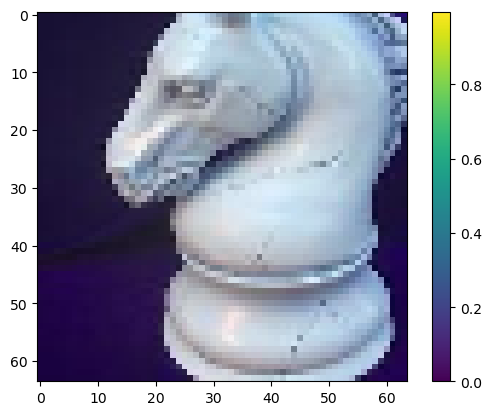

Knight
(64, 64, 3)


In [11]:
visualize_example(X[75]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_PIECES[y[75]]) # Acceso al diccionario
print(X[75].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [12]:
#batch_size=128
num_classes=6
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [224]:
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [222]:
X.shape

(7360, 64, 64, 3)

In [225]:
y.shape

(7360, 6)

### Parámetros por defecto de la capa de convolución:

Tenemos varias capas convolucionales con una función de activación relu, capas MaxPooling, un aplanamiento de las capas y dos capas de densidad junto a un dropout.

La regularización utilizada en ambos casos es una L2.

In [203]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(64, 64, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.02)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(6, activation='softmax', kernel_regularizer=keras.regularizers.L1L2(l2=0.02))
])

C:\Users\Javi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


El optimizador utilizado es el adam y la pérdida es una categorical_crossentropy al ser un problema de clasificación.

In [204]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 31, 31, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_154               │ (None, 6, 6, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_155               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,662 (2.62 MB)

 Trainable params: 686,662 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

*Observamos que el modelo tiene cerca de 3 millones de parámetros, se ha visto una mejora importante al añadir más neuronas en la capa dense_9, otros modelos probados con 200 neuronas solo alcanzaban un 65% de precisión. Hacemos dos máxpooling seguidos para reducir de 600000 a 4600 las neuronas en la capa flatten_5 y que no se dispare el número de parámetros pudiendo así aumentar el número de neuronas de la capa dense_9 que hemos observado mejora la precisión. Se usó categorical crossentropy porque las variables dependientes se transformaron en categorías y se usa la función de activation softmax en la capa de salida.*

**Comparación de modelos CNNs con un modelo de Fully Connected para este problema.**<br>
*El número de neuronas en la capa de entrada hace inviable entrenar un modelo Fully Connected que no usa capas convolucionales. Los filtros convolucionales permiten extraer características espaciales de las imágenes, frente a un modelo Fully Connected en el que no se aprovecha esta posibilidad.*


**Entrenamiento completo del mejor modelo.** <br>
*División de los datos en training/validation 80/20 para tener una buena estimación de los valores que nuestro modelo tendrá
en los datos de test, así como comprobar que no estamos cayendo en overfitting.*

In [205]:
history=model.fit(X, y, epochs=30, validation_split = 0.15)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.1901 - loss: 5.9198 - val_accuracy: 0.2618 - val_loss: 1.7350
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2991 - loss: 1.7239 - val_accuracy: 0.3732 - val_loss: 1.5645
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3700 - loss: 1.6125 - val_accuracy: 0.4475 - val_loss: 1.4977
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4390 - loss: 1.5313 - val_accuracy: 0.5272 - val_loss: 1.3982
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4862 - loss: 1.4493 - val_accuracy: 0.6114 - val_loss: 1.2869
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5638 - loss: 1.3428 - val_accuracy: 0.6268 - val_loss: 1.2410
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6028 - loss: 1.2908 - val_accuracy: 0.6486 - val_loss: 1.1783
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6276 - loss: 1.2200 - val_accu

**Análisis visual de los errores de la red.**

In [25]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

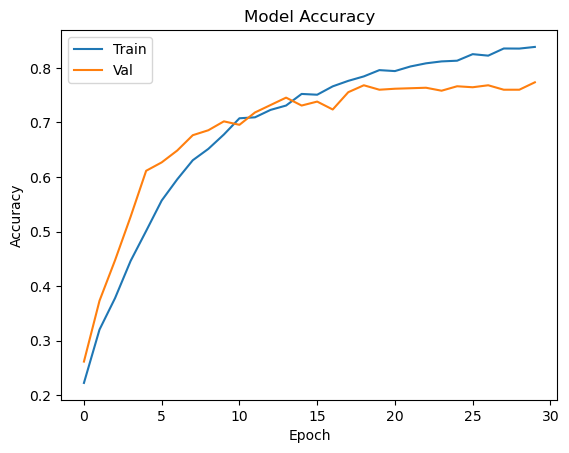

In [206]:
plot_acc(history)

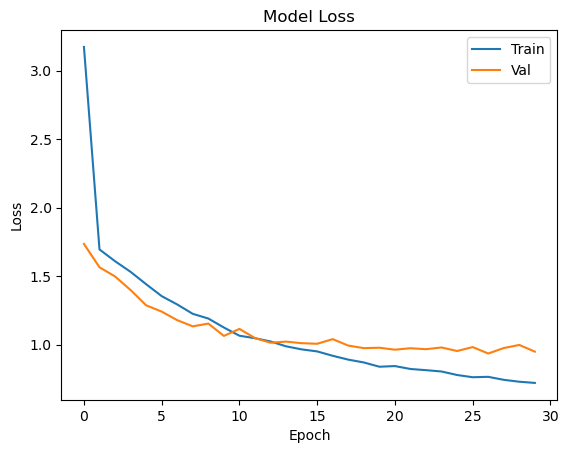

In [207]:
plot_loss(history)

*Viendo las gráficas observamos que con 5 épocas las líneas de loss y accuracy se vuelven prácticamente horizontales, por eso no seguimos entrenando.*

**Evaluación de los datos de test con este modelo.**

In [226]:
model.evaluate(X_val, y_val, batch_size=32, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5899 - loss: 1.6394


[1.528151512145996, 0.6329113841056824]

In [227]:
model.evaluate(X_test, y_test, batch_size=32, verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5560 - loss: 1.9893


[1.9177699089050293, 0.5730336904525757]

*Observamos que sobre los datos de test el loss es 0.17 y la precisión de un 94%*

**Almacenamos todas las predicciones para los datos de test.**

In [228]:
prediccion=model.predict(X_test, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [239]:
y_test.shape

(89, 6)

In [229]:
print(prediccion)
prediccion.shape

[[5.10874808e-01 1.97563663e-01 5.89910778e-04 2.27845177e-01
  6.20726384e-02 1.05387880e-03]
 [1.31186377e-03 1.40989678e-05 2.44074690e-04 9.98359859e-01
  5.13031068e-07 6.95484050e-05]
 [3.51968184e-02 2.34400947e-03 1.33126741e-03 9.60862458e-01
  6.22936932e-05 2.03085030e-04]
 [1.04508305e-03 9.36071992e-01 1.53303688e-06 5.03850097e-05
  6.27962723e-02 3.47476416e-05]
 [8.99039730e-02 1.04088344e-01 1.99819252e-01 4.62137982e-02
  3.23935568e-01 2.36039087e-01]
 [3.54224950e-01 1.04595356e-01 1.67721091e-03 1.96026415e-01
  2.93764144e-01 4.97119091e-02]
 [9.20410633e-01 6.25127032e-02 2.22370272e-05 5.19959116e-03
  1.17419679e-02 1.12862181e-04]
 [7.15785176e-02 5.17984927e-02 9.51531678e-02 3.74654531e-01
  7.40050375e-02 3.32810163e-01]
 [9.96180892e-01 8.47571646e-05 1.31084853e-05 2.55184574e-03
  1.06714084e-03 1.02299455e-04]
 [3.59593391e-01 6.49163220e-03 1.62773356e-01 3.83304149e-01
  3.70878726e-02 5.07495701e-02]
 [9.97094035e-01 6.84453640e-04 1.43406423e-05 2.0

(89, 6)

In [237]:
print(prediccion[0]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[0])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 18 clases.
print(predicho)
print(MAP_PIECES[predicho]) # Acceso al diccionario para mostrar el nombre del personaje predicho.

[0.5108748  0.19756366 0.00058991 0.22784518 0.06207264 0.00105388]
0
Bishop


In [232]:
y_test.shape

(89, 6)

**Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados.**

In [234]:
informe = classification_report(np.argmax(y_test,axis=1), np.argmax(prediccion,axis=1))
print(informe)

              precision    recall  f1-score   support

           0       0.62      0.36      0.45        14
           1       0.71      0.42      0.53        12
           2       0.88      0.88      0.88        17
           3       0.50      0.76      0.60        17
           4       0.29      0.38      0.33        13
           5       0.57      0.50      0.53        16

    accuracy                           0.57        89
   macro avg       0.60      0.55      0.56        89
weighted avg       0.60      0.57      0.57        89



In [254]:
mlb = MultiLabelBinarizer()
y_test_binary = mlb.fit_transform(y_test)
prediccion_binary = mlb.transform(prediccion)

cm = confusion_matrix(y_test_binary, prediccion_binary)
# Only use the labels that appear in the data
classes = classes[unique_labels(y_test_binary, prediccion_binary)]

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')
				
print(ax)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) [0.00010174902, 0.000102299455, 0.00011286218, 0.00012142466, 0.00012274756, 0.00013833912, 0.00014064746, 0.00014295457, 0.00014486314, 0.00015117615, 0.00015629991, 0.0001760295, 0.0001819924, 0.0001881401, 0.00020308503, 0.00020990311, 0.00022551963, 0.00024201084, 0.00024407469, 0.00025496268, 0.00026302252, 0.0002675342, 0.00027880826, 0.0002918358, 0.0003021465, 0.0003096209, 0.00032333282, 0.00034469814, 0.00034589562, 0.00035879322, 0.00036981888, 0.00037248826, 0.0004180803, 0.00042319892, 0.00043080578, 0.00043317646, 0.00044137312, 0.0004444667, 0.0004729257, 0.00053010765, 0.0005661782, 0.00057316263, 0.00057931594, 0.0005899108, 0.0006512473, 0.00066157203, 0.00068445364, 0.000731503, 0.000740874, 0.00074416725, 0.00078588835, 0.0007906582, 0.00082507235, 0.0008262969, 0.00087888935, 0.0008839426, 0.00096698996, 0.0009819976, 0.0010057973, 0.0010096165, 0.00103884

ValueError: multilabel-indicator is not supported

*Vemos que la menor precisión es del 85% al clasificar las imágenes de Homer Simpson (número 7), mientras que la mayor precisión se consigue al clasificar las imágenes correspondientes a Chief Wiggum (número 4) y Principal Skinner (número 16).*


**Mejoras** <br>
*Podríamos hacer data augmentation mediante el preprocesamiento de las imágenes predichas con menor precisión usando la clase ImageDataGenerator. Para ello podríamos fijarnos si están descentradas, oscuras etc. realizando transformaciones de rotación, desplazamientos y cambios de brillo según el caso.*


